![titanic](https://live.mrf.io/statics/i/ps/www.ecestaticos.com/imagestatic/clipping/0e4/7ce/0e47cec13bad958c0969e65495fdf2b0/como-fueron-los-ultimos-momentos-en-el-titanic-segun-la-carta-de-un-superviviente.jpg?mtime=1579565836)
# Titanic Data Project 

## Loading the data

The first thing that we need to do is load the data. The data is split into training and test data. In the case of the test data there is no "Survived" variable. We will use our model and the parameter values from the test data to make predictions of whether the people in the test set have survived 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')

# Random Seed 
np.random.seed(31415)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data_raw = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data_raw = pd.read_csv("/kaggle/input/titanic/test.csv")

# Exploring the data

### General view of data sets 

Let's take a look at the number and type of each variable in the training data. 

In [4]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that there are some missing values in the variables Age,Cabin and a few missing in Embarked. It will be worthwhile taking a closer look at these variabe to investigate how it will be best to transform the data before training a model with the data. 

In [5]:
train_data_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data_raw.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Persson, Mr. Ernst Ulrik",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [7]:
test_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We can also see that in the test data there are missing values in Age, Fare and Cabin. We should therefore apply the transformations to the test data before making predictions on this data. 

## Exploring each feature

We will now take a look at the possible values of each feature to see what information we can extract from these features and which transformations will be useful. 

In [8]:
# Function to calculate the column value breakdown 

def ColumnValueBreakdown(df, column):
    values_raw = df[column].value_counts()
    values_percent = df[column].value_counts()/len(df[column])
    new_df = pd.concat([values_raw,values_percent], axis=1)
    new_df.columns = ['Raw', 'Percentage']
    print(new_df)
    
    print('-'*10)
    
    print(df[[column,'Survived']].groupby(column, as_index=False).mean().sort_values(by='Survived', ascending=False).to_string(index=False))

## **Sex** 

In [9]:
ColumnValueBreakdown(train_data_raw,'Sex')

        Raw  Percentage
male    577    0.647587
female  314    0.352413
----------
    Sex  Survived
 female  0.742038
   male  0.188908


We can see that a much larger proportion of females have survived than men. This is likely to be an important feature when we begin to train our models. 

## **Pclass**  

In [10]:
ColumnValueBreakdown(train_data_raw, 'Pclass')

   Raw  Percentage
3  491    0.551066
1  216    0.242424
2  184    0.206510
----------
 Pclass  Survived
      1  0.629630
      2  0.472826
      3  0.242363


In [11]:
train_data_raw[['Pclass','Survived']].groupby('Pclass', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


The variable Pclass is ordinal and determines whether the passenger was in first, second, or third class. There seems to be corrlation between the class of the passenger and the survival rate.   

## **SibSp & Parch ** 

These variables represent the number of siblings/spouses onboard (SibSp) and the number of parent/children onboard (Parch) for each passenger. 

In [12]:
ColumnValueBreakdown(train_data_raw, 'SibSp')

   Raw  Percentage
0  608    0.682379
1  209    0.234568
2   28    0.031425
4   18    0.020202
3   16    0.017957
8    7    0.007856
5    5    0.005612
----------
 SibSp  Survived
     1  0.535885
     2  0.464286
     0  0.345395
     3  0.250000
     4  0.166667
     5  0.000000
     8  0.000000


In [13]:
ColumnValueBreakdown(train_data_raw, 'Parch')

   Raw  Percentage
0  678    0.760943
1  118    0.132435
2   80    0.089787
5    5    0.005612
3    5    0.005612
4    4    0.004489
6    1    0.001122
----------
 Parch  Survived
     3  0.600000
     1  0.550847
     2  0.500000
     0  0.343658
     5  0.200000
     4  0.000000
     6  0.000000


With SibSp and Parch it appears that most people travelled alone. It can also be seen that the people who travelled with one or two siblings/spouse/children/parents had a higher survival rate than those who travelled alone. It may be worthwhile to create a new feature called isAlone to represent this information.

## **Embarked ** 

In [14]:
ColumnValueBreakdown(train_data_raw, 'Embarked')

   Raw  Percentage
S  644    0.722783
C  168    0.188552
Q   77    0.086420
----------
Embarked  Survived
       C  0.553571
       Q  0.389610
       S  0.336957


With Embarked, it seems that almost 70% of the people who embarked, did so at Southampton. It also seems that people who embarked at Cherbourg have a higher survival rate although they have a smaller sample size. There are also two missing values in this variable which could be solved by imputting the mode.

In [15]:
train_data_raw['Survived'].value_counts()/len(train_data_raw['Survived'])

0    0.616162
1    0.383838
Name: Survived, dtype: float64

It is also worth noting that the training data has a survival rate of 61.6%. While not a completely balanced dataset this is not too worrying.

## ** Remaining Quantitative Variables **

The remaining quantitative variables have a large number of distinct values and so it may be more worthwhile analysing them using histograms. In this case I have used a scatter matrix on these features to analyse them. 

In [16]:
print("No of Age vals: ", train_data_raw['Age'].nunique())
print("No of Fare vals: ", train_data_raw['Fare'].nunique())

No of Age vals:  88
No of Fare vals:  248


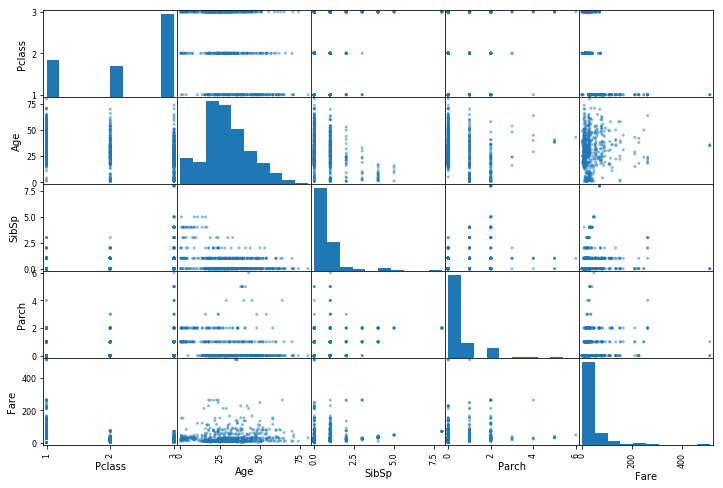

In [17]:
from pandas.plotting import scatter_matrix

# PassengerId and Survived not interesting for this scatter matrix
df = train_data_raw.drop(['PassengerId','Survived'], axis=1)
scatter_matrix(df, figsize = (12,8));

## ** Fare **

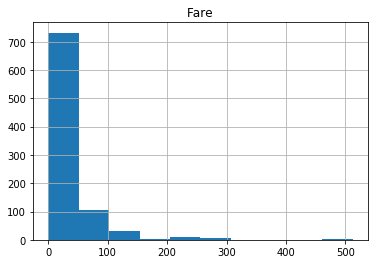

In [18]:
train_data_raw[['Fare']].hist();

The largest Fare value seems quite high so let's take a closer look at this variable to see if it appears to be an outlier. It may also be worth tranforming this variable to consider tickets within different price ranges.

## ** Age **

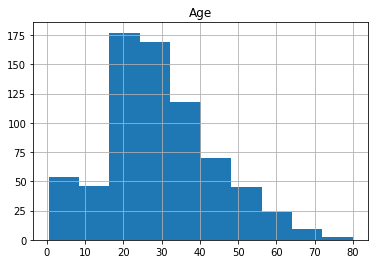

In [19]:
train_data_raw[['Age']].hist();

Age seems to follow a roughly normal distribution at first glance. For this it would be worth investigating whether our models would benefit from transforming the data to Age bands. 

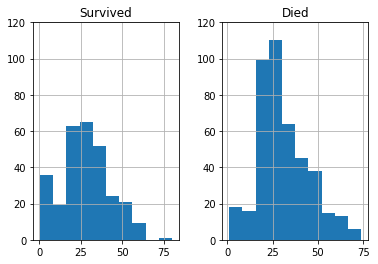

In [20]:
survived = train_data_raw[train_data_raw.Survived == 1]
died = train_data_raw[train_data_raw.Survived == 0]

fig, axes = plt.pyplot.subplots(1, 2)

survived[['Age']].hist(ax=axes[0]);
died[['Age']].hist(ax=axes[1]);
axes[0].title.set_text('Survived')
axes[1].title.set_text('Died')
axes[0].set(ylim=(0, 120));
axes[1].set(ylim=(0, 120));

## ** Remaining Qualitative Variables **

We are left to analyse the remaining qualitative variables which are Name, PassengerId, ticket number and cabin number. PassengerId and Ticket number do not give us any information and so can be dropped. Cabin number only has 204 instances and therefore it is very incomplete. However, it may be interesting to check see the use of a HasCabin parameter would be useful in our model. 

Finally, from reading other notebooks on this dataset it seems that although the names are individual names they have a lot of information in the title that is included in the name. I will be taking examples from [this notebook](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy) and [this one](https://www.kaggle.com/startupsci/titanic-data-science-solutions) to implement this

In [21]:
# Drop PassengerId & Ticket columns
train_df = train_data_raw.drop(['PassengerId','Ticket'], axis = 1) 

# Data Cleaning 

As previously discussed some of the features in the data are missing some values. In this part of the project we will write a function to imput these missing values to clean the data for better modelling results.
The raw training set is missing values for the parameters Age, Cabin and Embarked while the raw test set is missing values for Age, Fare and Cabin. 

As Cabin is missing a lot of values we will not imput values for this parameter as later we will drop the column after transforming the data to a new feature called "HasCabin". 

In [22]:
# We create this function to do the data imputation on null values.  
def DataImputation(df):
    #drop unneccessary columns 
    df = df.drop(['PassengerId','Ticket'], axis = 1) 
    
    # We can see that Age has missing values so we will fix that by imputing the median value for NaN values 
    median = df['Age'].median()
    df['Age'] = df['Age'].fillna(median)

    # Embarked is only missing a few values and it is a categorical variable so it will be best to impute these values
    # using the mode 
    mode = df['Embarked'].mode()
    df['Embarked'] = df['Embarked'].fillna(mode[0])
    
    # There is a missing fare in the test set which we can correct by calculating the median 
    fare_median = df['Fare'].median()
    df['Fare'] = df['Fare'].fillna(fare_median)
    
    return df 

train_df = DataImputation(train_data_raw)
test_df = DataImputation(test_data_raw)

train_df.info()
print("-" * 40)
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB


# Feature Engineering 

As we can see we now have completed the imputation of missing values (apart from Cabin) so we can now begin feature engineering to create some useful features we can use to do our modelling. 

The features we will create will be: 
* HasCabin - Whether a passenger has a cabin 
* IsAlone - Whether a passenger is travelling alone 
* NumFamily - Number of Family Members
* Title - Categorical variable based no the title of the passenger
* Age - Age will be converted into ranges 
* Fare - Will also be converted into ranges

In [23]:
# Create HasCabin Feature
def GenerateHasCabin(df):
    df['HasCabin'] = df['Cabin'].apply(lambda x: 1 if pd.notnull(x) else 0)
    

# Create IsAlone Feature
def GenerateIsAlone(df):
    df['IsAlone'] = np.where((df.SibSp == 0) & (df.Parch == 0), 1, 0) 

# Create NumFamily Feature
def GenerateNumFamily(df): 
    df['NumFamily'] = df['SibSp'] + df['Parch']

# Create AgeRange Feature 
def GenerateAgeRange(df):
    df['AgeRange'] = pd.cut(np.floor(df['Age']),4, labels=False)

# Create FareRange Feature
def GenerateFareRange(df):
    df['FareRange'] = pd.qcut(np.floor(df['Fare']),4, labels=False)


In [24]:
train_df['Title']=train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
test_df['Title']=test_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
print(train_df['Title'].value_counts())
print('-'*30)
print(test_df['Title'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Mme               1
Don               1
Ms                1
the Countess      1
Sir               1
Jonkheer          1
Capt              1
Name: Title, dtype: int64
------------------------------
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64


As we can see there are some titles that are different ways to write the same thing eg. Ms/Miss/Mlle. We will put these titles into one category. We will also put a set of rarer titles into a category called "Rare". 

In [25]:
rare_titles = ['Dr', 'Rev', 'Col','Major', 'Lady', 'Don', 'the Countess', 'Jonkheer', 'Capt', 'Sir','Dona']

# Create Title Feature: 
def GenerateTitleFeature(df):
    df['Title']=  df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme','Mrs'], 'Miss')
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    


In [26]:
def CreateNewFeatures(df):
    GenerateHasCabin(df)
    GenerateIsAlone(df)
    GenerateNumFamily(df)
    GenerateAgeRange(df)
    GenerateFareRange(df)
    GenerateTitleFeature(df)
    df = df.drop(['Cabin', 'Name'], axis=1)
    return df 

In [27]:
train_df = CreateNewFeatures(train_df)
test_df = CreateNewFeatures(test_df)

In [28]:
ColumnValueBreakdown(train_df, 'HasCabin')
print('-'*30)
ColumnValueBreakdown(train_df, 'IsAlone')
print('-'*30)
ColumnValueBreakdown(train_df, 'NumFamily')
print('-'*30)
ColumnValueBreakdown(train_df, 'AgeRange')
print('-'*30)
ColumnValueBreakdown(train_df, 'FareRange')
print('-'*30)
ColumnValueBreakdown(train_df, 'Title')

   Raw  Percentage
0  687    0.771044
1  204    0.228956
----------
 HasCabin  Survived
        1  0.666667
        0  0.299854
------------------------------
   Raw  Percentage
1  537    0.602694
0  354    0.397306
----------
 IsAlone  Survived
       0  0.505650
       1  0.303538
------------------------------
    Raw  Percentage
0   537    0.602694
1   161    0.180696
2   102    0.114478
3    29    0.032548
5    22    0.024691
4    15    0.016835
6    12    0.013468
10    7    0.007856
7     6    0.006734
----------
 NumFamily  Survived
         3  0.724138
         2  0.578431
         1  0.552795
         6  0.333333
         0  0.303538
         4  0.200000
         5  0.136364
         7  0.000000
        10  0.000000
------------------------------
   Raw  Percentage
1  563    0.631874
0  180    0.202020
2  126    0.141414
3   22    0.024691
----------
 AgeRange  Survived
        0  0.455556
        2  0.396825
        1  0.364121
        3  0.227273
---------------------------

In [29]:
from sklearn.preprocessing import LabelEncoder

# We convert the string values of Title, Embarked and Sex to numeric labels
label = LabelEncoder() 
train_df['Title'] = label.fit_transform(train_df['Title'])
test_df['Title'] = label.transform(test_df['Title'])
train_df['Sex'] = label.fit_transform(train_df['Sex'])
test_df['Sex'] = label.transform(test_df['Sex'])
train_df['Embarked'] = label.fit_transform(train_df['Embarked'])
test_df['Embarked'] = label.transform(test_df['Embarked'])





From the data we have here it seeems that people who have cabins had a lower survival rate than people who may not have had a cabin. However the data is very incomplete and we have no guarantee that a 0 in the HasCabin feature means that this passenger didn't have a cabin. We can take a closer look later to see how the models perform with this feature. 

We can also deduce from the training set that people who travelled alone had a lower survival rate than people who travelled with family members.
Younger people (<20) have the highest survival rate while older people (60-80) have the lowest. 
We can also see a relationship between the most expensive fares and high survival rate. 
Looking at the Title feature we can see that adult men (Mr) had the lowest survival rate while unmarried women (Miss) have the highest survival rate amongst the group. 

# Training Models

Now that we have cleaned our data and completed the feature engineering portion of the project we can now begin to train models and make predictions on our test set. 

The training will be done using cross-validation on the full training set to find the best model. After we select the best model we will try to improve the performance of the model using hyperparameter tuning.

In [30]:
# Import model selection and metric methods
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Import the models that we are going to consider
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier 

classifiers = [LogisticRegressionCV(), SGDClassifier(), SVC(), NuSVC(), LinearSVC(), KNeighborsClassifier(), 
               GaussianNB(), DecisionTreeClassifier(), BaggingClassifier(), 
               AdaBoostClassifier(), RandomForestClassifier(), XGBClassifier()]

# Separate the training data into X and Y features/response
# We have found that AgeRange and Fare Range work better than 
X_train = train_df.drop(['Survived'], axis=1) 
Y_train = train_df['Survived']

In [31]:
# Configure cross validation for models
cv = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0)

model_results = pd.DataFrame(columns = ['Model', 'Mean Train Accuracy', 'Mean Test Accuracy'])

index = 0 
for clf in classifiers:
    scores = cross_validate(clf, X_train, Y_train, scoring='accuracy', cv=cv, return_train_score=True)
    model_results.loc[index,'Model'] = clf
    model_results.loc[index,'Mean Train Accuracy'] = scores['train_score'].mean()
    model_results.loc[index,'Mean Test Accuracy'] = scores['test_score'].mean()
    index +=1
    
model_results.sort_values(by = ['Mean Test Accuracy'], ascending = False, inplace = True)
model_results

,Model,Mean Train Accuracy,Mean Test Accuracy
11,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.886677,0.835075
0,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.826324,0.826866
9,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.846549,0.822388
10,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.987159,0.820522
8,"BaggingClassifier(base_estimator=None, bootstr...",0.970787,0.820149
3,"NuSVC(break_ties=False, cache_size=200, class_...",0.826485,0.806716
6,"GaussianNB(priors=None, var_smoothing=1e-09)",0.801766,0.802239
7,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.987159,0.786567
4,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.782665,0.769776
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.805618,0.735821


If we look at the results we can see that the best performing classifier was XGBoost followed by RandomForest and then LogisticRegression. The SVM performed a worse than the tree based classifiers. I thought that the could be due to the fact that there is quite a large range between the lowest and highest values for Age and Fare. I decided to try to fit the models again after transforming these features

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

columns = ['Age', 'Fare']
norm_train = X_train
norm_train[columns] = scaler.fit_transform(X_train[columns]) 

We also create a test set with the transformed columns 

In [33]:
columns = ['Age', 'Fare']
norm_test = test_df
norm_test[columns] = scaler.transform(test_df[columns]) 

We will now train the models again with the normalised columns to see if this improves the performance 

In [34]:
model_results_norm = pd.DataFrame(columns = ['Model', 'Mean Train Accuracy', 'Mean Test Accuracy'])

index = 0 
for clf in classifiers:
    scores = cross_validate(clf, norm_train, Y_train, scoring='accuracy', cv=cv, verbose=0, return_train_score=True)
    model_results_norm.loc[index,'Model'] = clf
    model_results_norm.loc[index,'Mean Train Accuracy'] = scores['train_score'].mean()
    model_results_norm.loc[index,'Mean Test Accuracy'] = scores['test_score'].mean()
    index +=1
    
model_results_norm.sort_values(by = ['Mean Test Accuracy'], ascending = False, inplace = True)
model_results_norm

,Model,Mean Train Accuracy,Mean Test Accuracy
11,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.886677,0.835075
2,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.82825,0.827985
3,"NuSVC(break_ties=False, cache_size=200, class_...",0.826164,0.826866
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.859069,0.826493
4,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.828732,0.826119
0,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.827769,0.823881
10,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.987159,0.823134
9,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.846549,0.822388
8,"BaggingClassifier(base_estimator=None, bootstr...",0.969181,0.817164
6,"GaussianNB(priors=None, var_smoothing=1e-09)",0.801766,0.802239


We can now see that when we use a MinMaxScaler to standardise the features of Age and Fare the performance of the SVMs improve. While XGBoost continues to be the best classifier we find that the SVM based algorithms perform better than the tree based models.

We will now take a subsection of these algorithms and do further analysis through Feature Selection and hyperparameter tuning to try to squeeze the best possible performance from the models. 

The algorithms we will take a closer look at will be XGBoost, SVC, KNN, Logistic Regression and Random Forest.
These are the models that performed best between the two test and also represent different algorithm methods. 

# Feature Selection and Hyperparameter Tuning 

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

best_clfs = [LogisticRegressionCV(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier()]


grid_params = [[{
        # LogisticRegressionCV()
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear'],
        'clf__max_iter': [50, 100, 200, 500],
        'clf__random_state': [0]
    }, 
    {
        # LogisticRegressionCV()
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs'],
        'clf__max_iter': [50, 100, 200, 500],
        'clf__random_state': [0]
    }],
    [{
        # KNeighborsClassifier()
        'clf__n_neighbors': [3,5,10,20], 
        'clf__weights': ['uniform', 'distance'],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    [{
        # SVC()
        'clf__C': [0.1,0.5, 1, 1.5],
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__random_state': [0]
    }],
    [{
        # RandomForestClassifier()
        'clf__n_estimators': [25, 50, 100, 200],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 2,5,10],
        'clf__random_state': [0]
    }],
    [{
        # XGBClassifier()
        'clf__learning_rate': [.01, .03, .05, .1, .25],
        'clf__max_depth': [10,12,14,16, 20],
        'clf__n_estimators': [25, 50, 100, 200],
        'clf__seed': [0]
    }]
    
]

## Pipeline with RFECV

In [36]:
results_hyper = pd.DataFrame(columns = ['Model', 'Best Params', 'Mean Train Accuracy', 'Mean Test Accuracy'])

index = 0 
for clf, grid in zip(best_clfs, grid_params):
    pipe = Pipeline([('rfe', RFECV(estimator=SVC(kernel="linear"), step=1, cv=cv, scoring='accuracy')),
                    ('clf', clf)])
    
    gridsearch = GridSearchCV(pipe, grid, scoring = 'accuracy', cv = cv, return_train_score=True)
    gridsearch.fit(X_train, Y_train)
    best_idx = gridsearch.best_index_
    results_hyper.loc[index,'Model'] = clf
    results_hyper.loc[index,'Best Params'] = str(gridsearch.best_params_)
    results_hyper.loc[index,'Mean Train Accuracy'] = gridsearch.cv_results_['mean_train_score'][best_idx]
    results_hyper.loc[index,'Mean Test Accuracy'] = gridsearch.cv_results_['mean_test_score'][best_idx]
    index += 1


results_hyper.sort_values(by = ['Mean Test Accuracy'], ascending = False, inplace = True)

results_hyper

,Model,Best Params,Mean Train Accuracy,Mean Test Accuracy
3,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'clf__criterion': 'entropy', 'clf__max_depth'...",0.942055,0.842537
4,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'clf__learning_rate': 0.03, 'clf__max_depth':...",0.917496,0.838433
2,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf__C': 1, 'clf__gamma': 'auto', 'clf__kern...",0.828892,0.827612
0,"LogisticRegressionCV(Cs=10, class_weight=None,...","{'clf__max_iter': 50, 'clf__penalty': 'l1', 'c...",0.82809,0.823134
1,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'clf__algorithm': 'brute', 'clf__n_neighbors'...",0.831621,0.81903


We can see that in this case the best performing model was Random Forest followed by XGBoost. However this could be due to the feature selection method that we have chosen. Now we will investigate by using SelectFromModel to see if we can generate a better performing model 

## Gridsearch without Feature Selection  

Now finally lets investigate a normal gridsearch but without any feature selection method in the pipline and see how this performs. It could be that the models perform best with all of the features included in the selection process

In [37]:
clfs = [LogisticRegressionCV(), RandomForestClassifier(), XGBClassifier(),KNeighborsClassifier(), SVC()]

grid_params = [[{
        # LogisticRegressionCV()
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear'],
        'clf__max_iter': [50, 100, 200, 500],
        'clf__random_state': [0]
    }, 
    {
        # LogisticRegressionCV()
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs'],
        'clf__max_iter': [50, 100, 200, 500],
        'clf__random_state': [0]
    }],
    [{
        # RandomForestClassifier()
        'clf__n_estimators': [150, 200, 250, 300],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [8,10, 12, 16],
        'clf__random_state': [0]
    }],
    [{
        # XGBClassifier()
        'clf__learning_rate': [.01, .03, .05],
        'clf__max_depth': [8,9,10,12],
        'clf__n_estimators': [25, 35, 50],
        'clf__seed': [0]
    }],
    [{
        # KNeighborsClassifier()
        'clf__n_neighbors': [3,5,10,20], 
        'clf__weights': ['uniform', 'distance'],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    [{
        # SVC()
        'clf__C': [0.1,0.5, 1, 1.5],
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__random_state': [0]
    }]
]

results_hyper_grid = pd.DataFrame(columns = ['Model', 'Best Params', 'Mean Train Accuracy', 'Mean Test Accuracy'])

index = 0 
for clf, grid in zip(clfs, grid_params):
    pipe = Pipeline([('clf', clf)])
    gridsearch = GridSearchCV(pipe, grid, scoring = 'accuracy', cv = cv, return_train_score=True)
    gridsearch.fit(X_train, Y_train)
    best_idx = gridsearch.best_index_
    results_hyper_grid.loc[index,'Model'] = clf
    results_hyper_grid.loc[index,'Best Params'] = str(gridsearch.best_params_)
    results_hyper_grid.loc[index,'Mean Train Accuracy'] = gridsearch.cv_results_['mean_train_score'][best_idx]
    results_hyper_grid.loc[index,'Mean Test Accuracy'] = gridsearch.cv_results_['mean_test_score'][best_idx]
    index += 1


results_hyper_grid.sort_values(by = ['Mean Test Accuracy'], ascending = False, inplace = True)
results_hyper_grid

,Model,Best Params,Mean Train Accuracy,Mean Test Accuracy
1,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'clf__criterion': 'entropy', 'clf__max_depth'...",0.917014,0.84291
2,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'clf__learning_rate': 0.05, 'clf__max_depth':...",0.909791,0.840299
4,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker...",0.82825,0.827985
3,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'clf__algorithm': 'auto', 'clf__n_neighbors':...",0.859069,0.826493
0,"LogisticRegressionCV(Cs=10, class_weight=None,...","{'clf__max_iter': 50, 'clf__penalty': 'l1', 'c...",0.827769,0.824254


In [38]:
grid =  [{
        # KNeighborsClassifier()
        'n_neighbors': [3,5,10,20], 
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }]

gridsearch = GridSearchCV(KNeighborsClassifier(), grid, scoring = 'accuracy', cv = cv, return_train_score=True)
gridsearch.fit(norm_train, Y_train)

best_idx = gridsearch.best_index_
print(str(gridsearch.best_params_))

print(gridsearch.cv_results_['mean_train_score'][best_idx])
print(gridsearch.cv_results_['mean_test_score'][best_idx])


{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
0.8590690208667737
0.8264925373134329


# Predictions  

We have now determined the best models and the best performing hyperparameters for each of the models. We will now use these best performing models on the test set and submit our predictions for the competition. 

In [39]:
from sklearn.metrics import accuracy_score

#Train best model - RandomForest
best_model = RandomForestClassifier(criterion='entropy', max_depth= 8,n_estimators=150, random_state=0)
best_model.fit(X_train,Y_train)
pred = best_model.predict(X_train)
score = accuracy_score(Y_train, pred)

print("Test Prediction accuracy: ", score)

test_df['Survived'] = best_model.predict(test_df)
submit = pd.concat([test_data_raw['PassengerId'], test_df['Survived']], axis=1, sort=False)
submit.to_csv("submit_random_forest.csv", index=False)

Test Prediction accuracy:  0.9023569023569024


The Random Forest model corresponds to a prediction accuracy of 77.511% on the test set 

In [40]:
test_df= test_df.drop('Survived', axis=1)
#Train best model - XGBClassifier
best_model = XGBClassifier(learning_rate=0.05, max_depth=8, n_estimators= 50, seed=0)
best_model.fit(X_train,Y_train)
pred = best_model.predict(X_train)
score = accuracy_score(Y_train, pred)

print("Test Prediction accuracy: ", score)

test_df['Survived'] = best_model.predict(test_df)
submit = pd.concat([test_data_raw['PassengerId'], test_df['Survived']], axis=1, sort=False)
submit.to_csv("submit_xgb.csv", index=False)

Test Prediction accuracy:  0.9102132435465768


The XGBoost model corresponds to 0.77033% prediction accuracy. 

In [41]:
test_df= test_df.drop('Survived', axis=1)
#Train best model - SVC
best_model = SVC(C= 1, gamma='scale', kernel='rbf', random_state=0)
best_model.fit(norm_train,Y_train)
pred = best_model.predict(X_train)
score = accuracy_score(Y_train, pred)

print("Test Prediction accuracy: ", score)

test_df['Survived'] = best_model.predict(test_df)
submit = pd.concat([test_data_raw['PassengerId'], test_df['Survived']], axis=1, sort=False)
submit.to_csv("submit_svc.csv", index=False)

Test Prediction accuracy:  0.8294051627384961



The SVC model returned a score of 78.9% accuracy on the test set.

# Conclusion

We have taken a look at a number of different prediction algorithms and also investigated feature selection. In this case we found that at least for our tranformations of the data better models were trained without feature selection but of course this may not be the case if we did more feature engineering or a different feature selection method. 

We found a best test score of 78.9% which I don't feel is too bad. However I was surprised by the rather low performance of the XGBoost model given the high training accuracy scored. This suggests some overfitting in the model. Some future work could be to try to improve the model by taking a future look at hyperparameters and possibly the use of regularisation method such as ridge or lasso to prevent overfitting  